# pfceval | Detailed evaluation template

This notebooks shows how to do a detailed evaluation for two psudo forecasts.

### Prepare Evaluation reports

In [1]:
import os
import numpy as np
import polars as pl
import tempfile

from itertools import product
from datetime import datetime, timedelta


def get_example_forecast_paths(n_files=2, skip_existing=False):
    """
    Checks if example forecast files exist in a temp directory.
    If not, generates synthetic forecast data and saves them.
    Column names: model_time, valid_time, station_id, step, wind_speed, 
        unseen_sta, run_id, predq{0-9}

    Args:
        n_files (int): Number of forecast files to generate if they don't exist.
        n_rows (int): Number of rows per file.

    Returns:
        List[str]: Paths to forecast files.
    """
    # Use system temp directory
    temp_dir = os.path.join(tempfile.gettempdir(), "pfceval_example_forecasts")
    os.makedirs(temp_dir, exist_ok=True)

    file_paths = [
        os.path.join(temp_dir, f"example_forecast_{i}.parquet")
        for i in range(n_files)
    ]

    # Check if files already exist
    if all(os.path.exists(path) for path in file_paths) and skip_existing:
        print("Reading from sythetic forecasts from file.")
        return file_paths

    # Generate synthetic forecast data
    stations = [101, 102, 103, 104, 105]
    unseen_sta = {101: True, 102: True, 103: False, 104: False, 105: False}
    latitudes = {101: 52.11, 102: 51.52, 103: 53.44, 104: 54.01, 105: 51.75}
    longitudes = {101: 5.18, 102: 4.87, 103: 6.23, 104: 5.26, 105: 4.54}
    run_ids = list(range(100))
    n_ens = 20
    start_date = datetime(year=2022, month=1, day=2)
    model_run_time = pl.select(pl.date_range(
        start=start_date, 
        end=start_date + timedelta(days=len(run_ids)), 
        interval="1d",
    )).to_numpy().squeeze()
    model_run_time = {
        run_id: run_time for run_id, run_time in zip(run_ids, model_run_time)}
    steps = list(range(1, 15))

    rows = [{
        "model_time": str(model_run_time[run_id]),
        "station_id": station_id,
        "step": step,
        "unseen_sta": unseen_sta[station_id],
        "latitude": latitudes[station_id],
        "longitude": longitudes[station_id],
        "run_id": run_id,
    } for run_id, station_id, step in product(run_ids, stations, steps)]

    df = pl.DataFrame(rows)
    df = df.with_columns(
        valid_time=(pl.col("model_time").str.to_datetime() + pl.duration(hours=pl.col("step"))),
        model_time=pl.col("model_time").str.to_datetime(),
        step=pl.duration(hours=pl.col("step")),
    )
    n_rows = df.shape[0]

    ws = np.random.standard_normal(size=n_rows)

    for i, path in enumerate(file_paths):
        # Add wind speed column and scale it
        df = df.with_columns(
            wind_speed=ws,
        ).with_columns(
            wind_speed=(pl.col("wind_speed") * 2 + 15).clip(0)
        )

        # Step duration in hours
        step_hours = df.select(pl.col("step").dt.total_hours()).to_numpy().squeeze()

        forecast_bias = 1 * (1 - np.exp(-step_hours / 20))  # time scale ~1 day

        # Row-wise random shift
        shift = np.random.uniform(-0.5 - forecast_bias, 0.5 + forecast_bias, size=n_rows)
        randomness = np.random.normal(1.1, 0.2, size=n_rows)
        # Ensemble quantile predictions
        df = df.with_columns(
            **{
                f"pred_q{ens}": (
                    pl.col("wind_speed") +
                    shift * (1 + i * 0.1) +
                    ((1 / (n_ens * 2) + ens / n_ens) - 0.5)
                    * randomness * (1 / np.exp(-step_hours / 25))
                ).clip(0)
                for ens in range(n_ens)
            }
        )
        df.write_parquet(path)

    return file_paths

In [5]:
import pfceval
import polars as pl

from dataclasses import dataclass

@dataclass
class DetailedEvalConfig():
    index_cols = ["valid_time", "station_id", "step"]
    eval_ths = [14, 15, 16, 17]
    save_dir = "."
    lead_time_col = "step"
    location_id_col = "station_id"
    ensemble_prefix = "pred_q"
    obs_col = "wind_speed"
    bootstrap_col = "run_id"
    n_bootstrap_iter = 1
    rank_histogram_bins = 10
    CI = 0.9

    construct_eval_reports = True

config = DetailedEvalConfig()


def get_detailed_evaluation_report(forecast, experiment_name):

    calc = pfceval.Calculator(forecast, config.index_cols)
    calc.add_absolute_error()
    calc.add_squared_error()
    # Add probabilistic metrics
    calc.add_spread()
    calc.add_crps()
    # Add threshold based metrics
    for th in config.eval_ths:
        calc.add_twcrps(th)
        calc.add_brier(th)

    # fill_evaluation is a quick way to create an Evaluation.
    # Custom evaluations also can be done without using it.
    report = pfceval.Evaluation.fill_evaluation(
        experiment_name=experiment_name,
        calculator=calc, 
        lead_time_col=config.lead_time_col,
        location_id_col=config.location_id_col,
        bootstrap=True, 
        n_iter=config.n_bootstrap_iter, 
        CI=config.CI,
        location_metrics=True,
    )

    for th in config.eval_ths:
        report.add_brier_decomp(
            calculator=calc,
            th=th,
            n_iter=config.n_bootstrap_iter,
            CI=config.CI
        )

    report.add_rank_histogram(
        calculator=calc,
        n_bins=config.rank_histogram_bins,
    )

    return report

# Generate psudo forecasts
# forecast_paths = pfceval.utils.get_example_forecast_paths()
forecast_paths = get_example_forecast_paths()

exp_names = []
for i, forecast_path in enumerate(forecast_paths):
    forecast = pfceval.Forecast(
        fc_path=forecast_path,
        ensemble_prefix=config.ensemble_prefix,
        obs_col=config.obs_col,
        bootstrap_cols=config.bootstrap_col,
        load_to_memory=True
    )

    if i == 1:
        forecast.forecast = forecast.forecast.head(forecast.nrows() - 1)

    exp_name = f"DetailedEvaluationTemplate_{i}"
    exp_names.append(exp_name)
    report = get_detailed_evaluation_report(
        forecast=forecast, 
        experiment_name=exp_name
    )
    # Get metrics for the stations that is not present the training data
    unseen_report = get_detailed_evaluation_report(
        forecast=forecast.filter(pl.col("unseen_sta") == True), 
        experiment_name=exp_name
    )
    # Get a common report for all filters by combining them
    # The reports on right will have the right_prefix in their tables
    report.extend(unseen_report, right_prefix="unseen")
    # Save the report to disk
    report.save_results(f"{config.save_dir}/{exp_name}")

### Load the evaluation reports and analyze 

The begining is the same with basic evaluation but detailed one also includes rank histograms, reliability plots and brier decomposition

In [6]:
# Read reports from location
reports = [pfceval.Evaluation.load_report(f"./{path}") for path in exp_names]

overall = pfceval.plotting.stack_overall_metrics(*reports)
overall.sort("mae")

experiment,twcrps_th:15,brier_th:14,spread,brier_th:15,twcrps_th:14,twcrps_th:17,mae,brier_th:16,crps,twcrps_th:16,brier_th:17,mse
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""DetailedEvaluationTemplate_0""",0.13549,0.044995,0.445651,0.05452,0.186341,0.04398,0.399133,0.045329,0.270615,0.085176,0.031576,0.219473
"""DetailedEvaluationTemplate_1""",0.149695,0.050339,0.446688,0.059165,0.206659,0.049678,0.437686,0.052556,0.299078,0.094,0.035027,0.264284


In [7]:
unseen_overall = pfceval.plotting.stack_overall_metrics(*reports, table_name="unseen_overall_metrics")
unseen_overall.sort("mae")

experiment,twcrps_th:15,brier_th:14,spread,brier_th:15,twcrps_th:14,twcrps_th:17,mae,brier_th:16,crps,twcrps_th:16,brier_th:17,mse
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""DetailedEvaluationTemplate_0""",0.134824,0.04436,0.446931,0.054706,0.186667,0.046186,0.398611,0.046162,0.270698,0.085917,0.032817,0.219529
"""DetailedEvaluationTemplate_1""",0.148113,0.055265,0.446464,0.059079,0.205054,0.049197,0.434876,0.05179,0.298291,0.09256,0.034578,0.263963


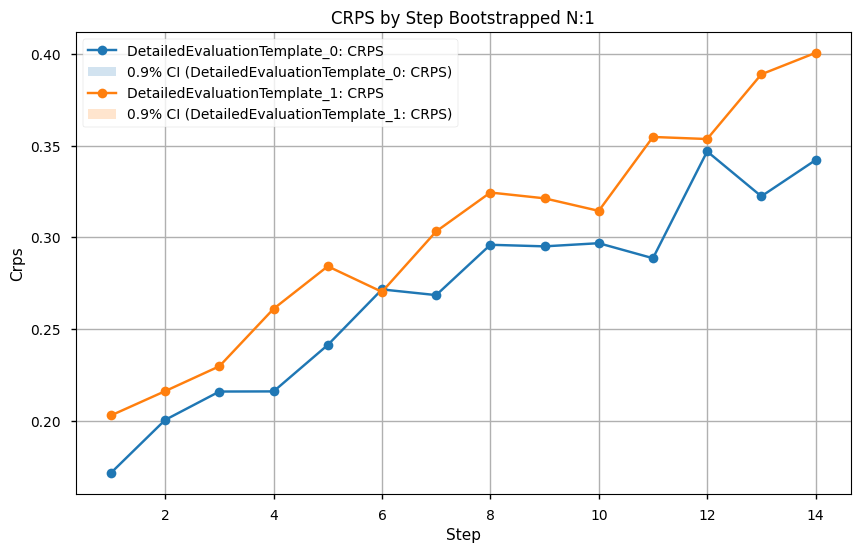

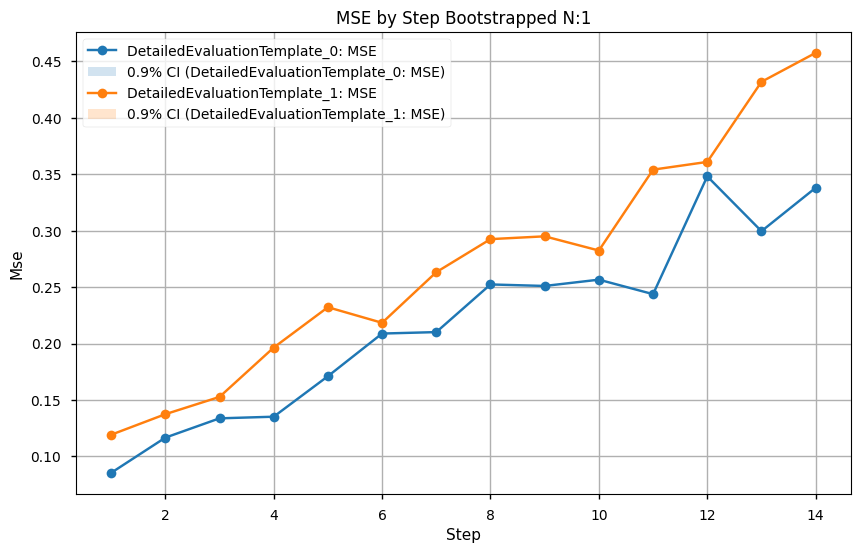

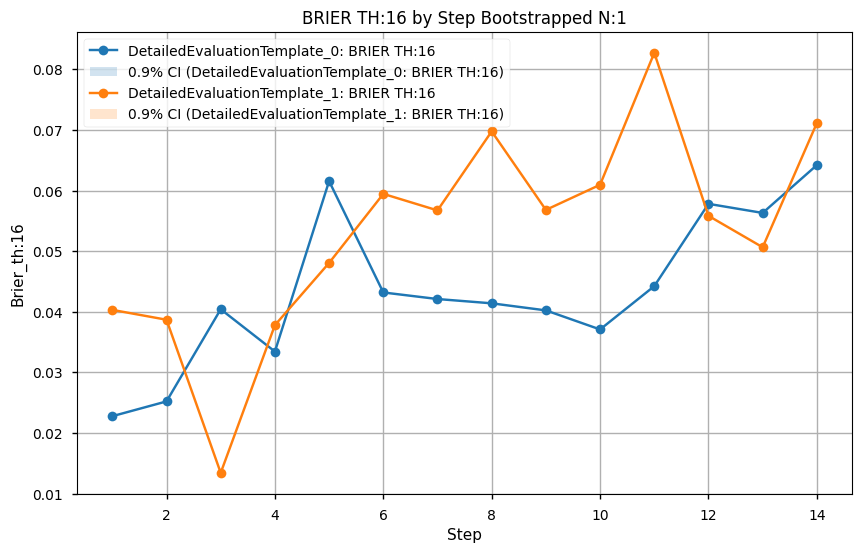

In [8]:
pfceval.plotting.plot_lead_time_metrics(*reports, table_name="unseen_bootstraped_lead_time_metrics", metrics=["crps", "mse", "brier_th:16"])

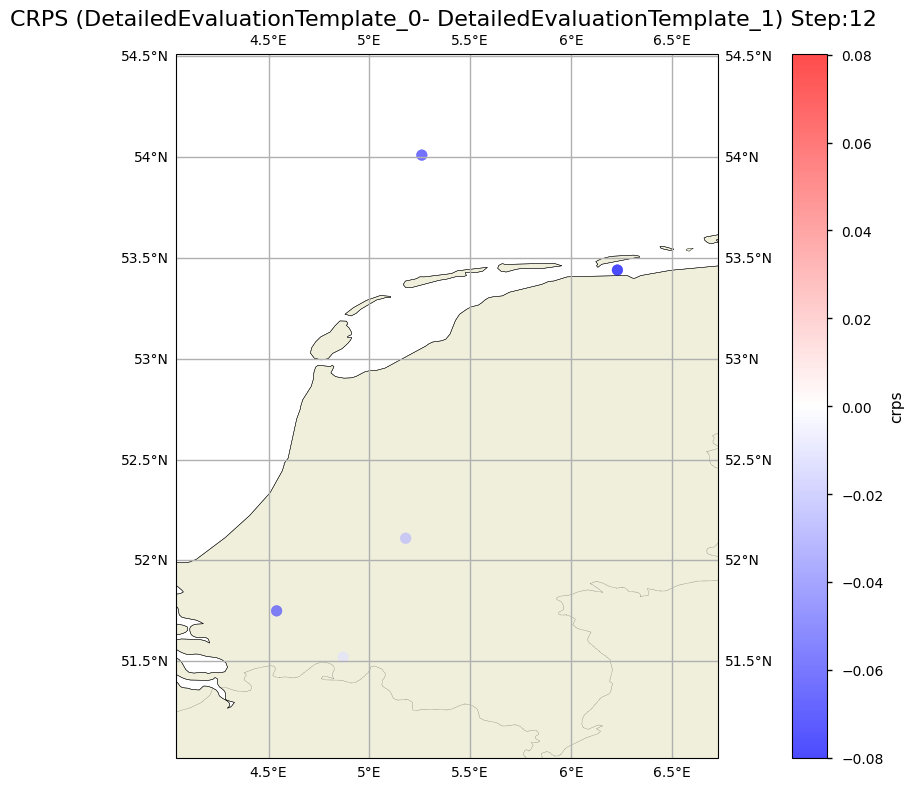

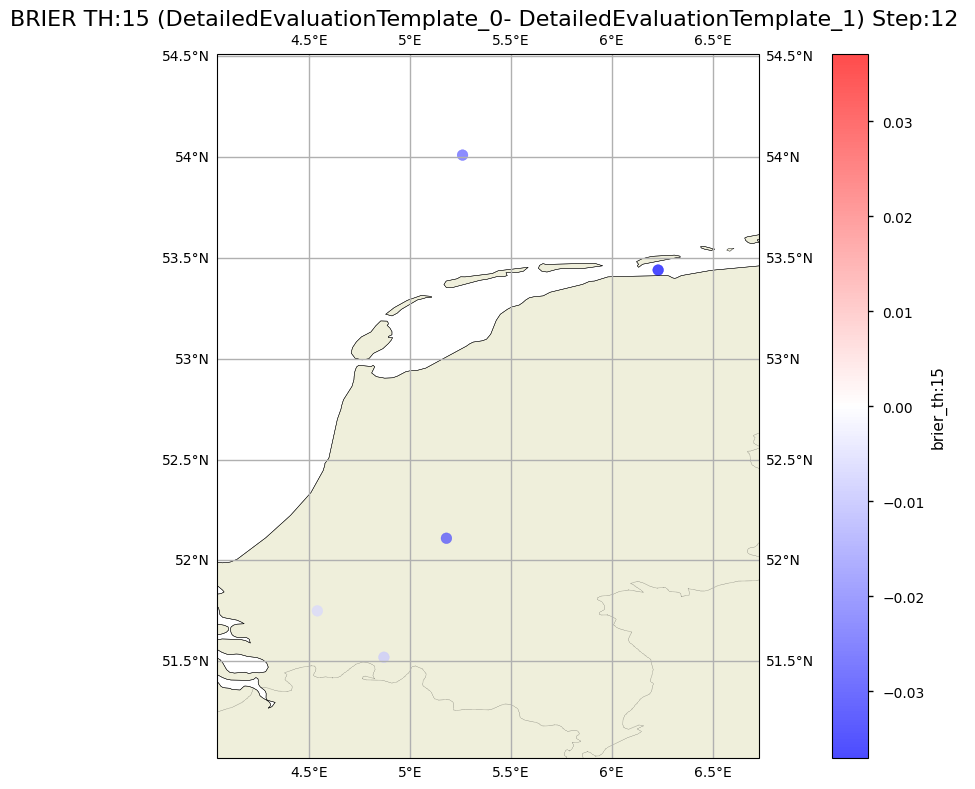

In [10]:
pfceval.plotting.plot_location_metrics(
    step=12, 
    evaluation=reports[0], 
    compare_with=reports[1], 
    metrics=["crps", "brier_th:15"], 
    cmap="bwr", 
    dot_size=60, 
    tol=0.5,
)

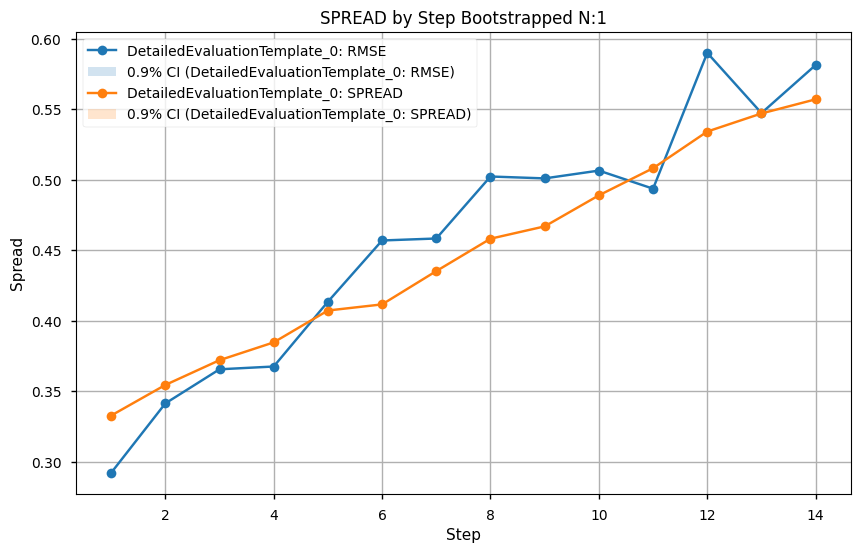

In [11]:
pfceval.plotting.plot_spread_rmse(reports[0], table_name="unseen_bootstraped_lead_time_metrics")

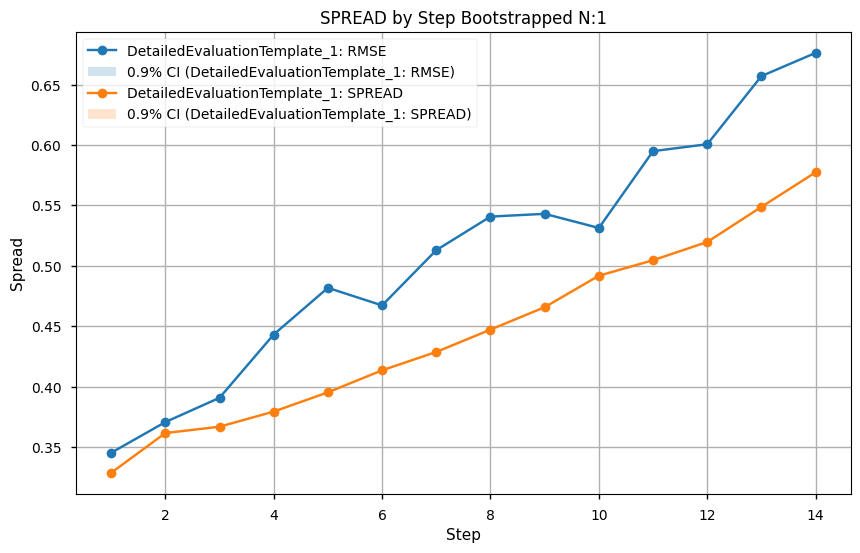

In [12]:
pfceval.plotting.plot_spread_rmse(reports[1], table_name="unseen_bootstraped_lead_time_metrics")

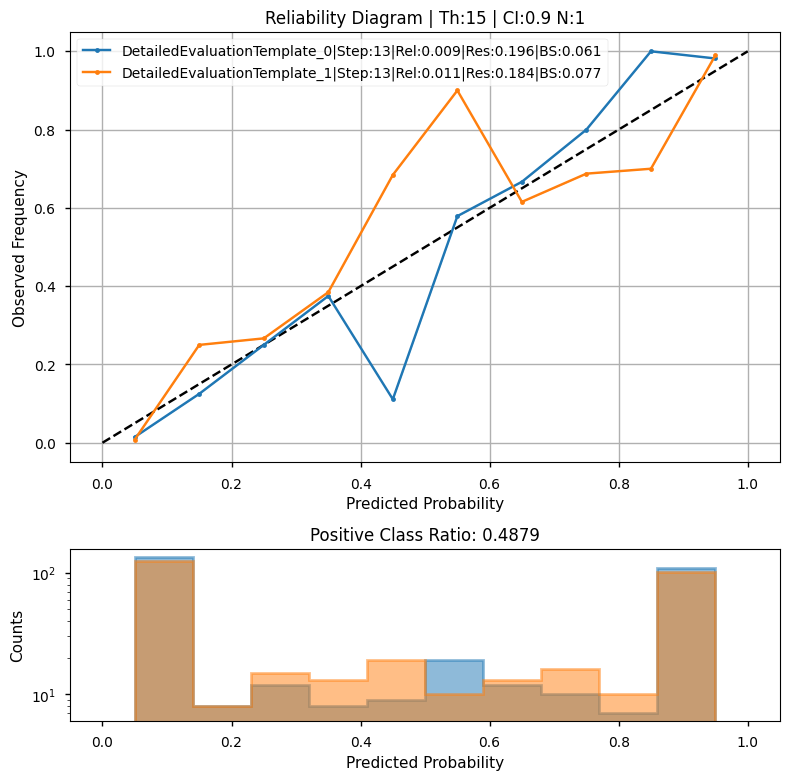

In [13]:
pfceval.plotting.plot_reliability_diagram(*reports, step=13, table_name="bootstrapped_obs_bar_th:15", nbins=10)

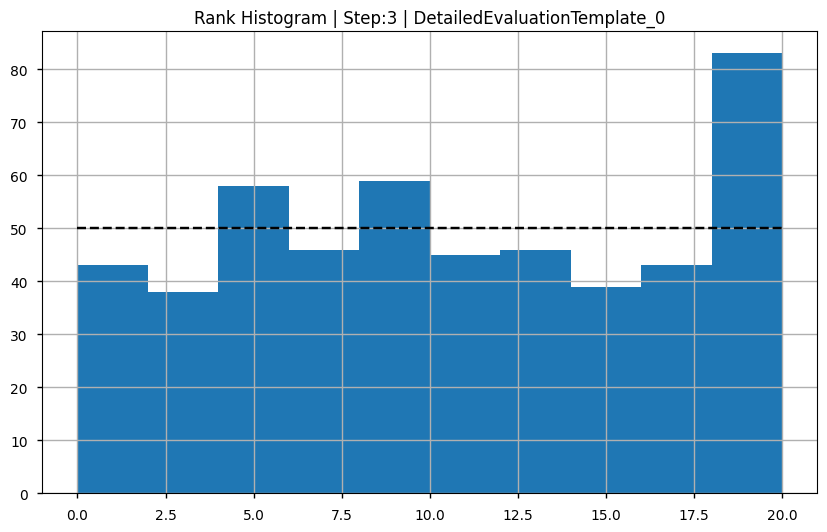

In [14]:
pfceval.plotting.plot_rank_histogram(reports[0], step=3)

In [ ]:
pfceval.plotting.plot_lead_time_metrics(*reports, table_name="unseen_bootstrapped_brier_decomp_th:15")

In [167]:
reports[0].tables()

['overall_metrics',
 'lead_time_metrics',
 'lead_time_location_metrics',
 'station_meta',
 'bootstraped_lead_time_metrics',
 'bootstrapped_brier_decomp_th:15',
 'bootstrapped_obs_bar_th:15',
 'lead_time_rank_histogram',
 'unseen_overall_metrics',
 'unseen_lead_time_metrics',
 'unseen_lead_time_location_metrics',
 'unseen_station_meta',
 'unseen_bootstraped_lead_time_metrics',
 'unseen_bootstrapped_brier_decomp_th:15',
 'unseen_bootstrapped_obs_bar_th:15',
 'unseen_lead_time_rank_histogram']